In [1]:
from gatenlp import Document
from gatenlp.corpora import ListCorpus
from GatenlpUtils import loadCorpus, create_gold_standard_json

In [2]:
from gatenlp.visualization import CorpusViewer

corpus = loadCorpus()
viewer = CorpusViewer(corpus)
viewer.show()

### Check documents for section annotations

In [ ]:
# Check if each document has the "Section" annotation set
# and if it contains the required annotation types
print("Checking annotation sets in corpus documents...")
print("=" * 60)

annotation_types = ["Procedure", "Circumstances", "Law", "Decision"]
missing_sections = []
incomplete_sections = []

for i, doc in enumerate(corpus):
    doc_name = doc.features.get("gate.SourceURL", f"Document {i+1}")
    print(f"\nDocument: {doc_name}")
    section = doc.annset("Section")
    if section:
        for annotation_type in annotation_types:
            if section.with_type(annotation_type):
                print(f"  Found '{annotation_type}' annotation in {doc_name}.")
            else:
                print(f"  Missing '{annotation_type}' annotation in {doc_name}.")
                incomplete_sections.append(doc_name)
    else:
        print(f"  No 'Section' annotation set found in {doc_name}.")
        missing_sections.append(doc_name)
        continue

print("\n" + "=" * 60)
print("Summary:")
print(f"Total documents: {len(corpus)}")
print(f"Documents missing 'Section' annotation set: {len(missing_sections)}")
print(f"Documents with incomplete section annotations: {len(incomplete_sections)}")

    

Checking annotation sets in corpus documents...

Document: file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx
  Found 'Procedure' annotation in file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx.
  Found 'Circumstances' annotation in file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx.
  Found 'Law' annotation in file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx.
  Found 'Decision' annotation in file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx.

Document: file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx
  Found 'Procedure' annotation in file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx.
  Found 'Circumstances' annotation in file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx.
  Found 'Law' annotation in file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx.
  Found 'Decision' anno

### Create gold standard json of all documents

In [3]:
create_gold_standard_json()

Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF M.T. v. UKRAINE

### Count tokens

In [14]:
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer

nlp = English()
tokenizer = Tokenizer(nlp.vocab)

for doc in corpus:
    print(f"Processing document: {doc.features.get("gate.SourceURL")}")
    annotations = doc.annset("Section")
    # Procedure
    procedure_annotations = annotations.with_type("Procedure")
    for ann in procedure_annotations:
        procedure_text = doc.text[ann.start:ann.end]
        proc_tokens = tokenizer(procedure_text)
    # Circumstances
    circumstances_annotations = annotations.with_type("Circumstances")
    for ann in circumstances_annotations:
        procedure_text = doc.text[ann.start:ann.end]
        circ_tokens = tokenizer(procedure_text)
    # Decision
    decision_annotations = annotations.with_type("Decision")
    for ann in decision_annotations:
        procedure_text = doc.text[ann.start:ann.end]
        dec_tokens = tokenizer(procedure_text)
    
    total_tokens = len(proc_tokens) + len(circ_tokens) + len(dec_tokens)

    print(f"Procedure tokens: {len(proc_tokens)}")
    print(f"Circumstances tokens: {len(circ_tokens)}")
    print(f"Decision tokens: {len(dec_tokens)}")
    print(f"Total tokens: {total_tokens}")


Processing document: file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx
Procedure tokens: 168
Circumstances tokens: 1397
Decision tokens: 210
Total tokens: 1775
Processing document: file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx
Procedure tokens: 274
Circumstances tokens: 883
Decision tokens: 217
Total tokens: 1374
Processing document: file:/C:/Users/mnavas/CASE%20OF%20BIGUN%20v.%20UKRAINE.docx
Procedure tokens: 121
Circumstances tokens: 1412
Decision tokens: 225
Total tokens: 1758
Processing document: file:/C:/Users/mnavas/CASE%20OF%20CABUCAK%20v.%20GERMANY.docx
Procedure tokens: 177
Circumstances tokens: 2749
Decision tokens: 22
Total tokens: 2948
Processing document: file:/C:/Users/mnavas/CASE%20OF%20CAN%20v.%20TURKEY.docx
Procedure tokens: 134
Circumstances tokens: 506
Decision tokens: 145
Total tokens: 785
Processing document: file:/C:/Users/mnavas/CASE%20OF%20CRISTIAN%20CATALIN%20UNGUREANU%20v.%20ROMANIA.docx
Procedure tokens: 13

C:\Users\z0046bhj\AppData\Local\Temp\ipykernel_26580\3485300595.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


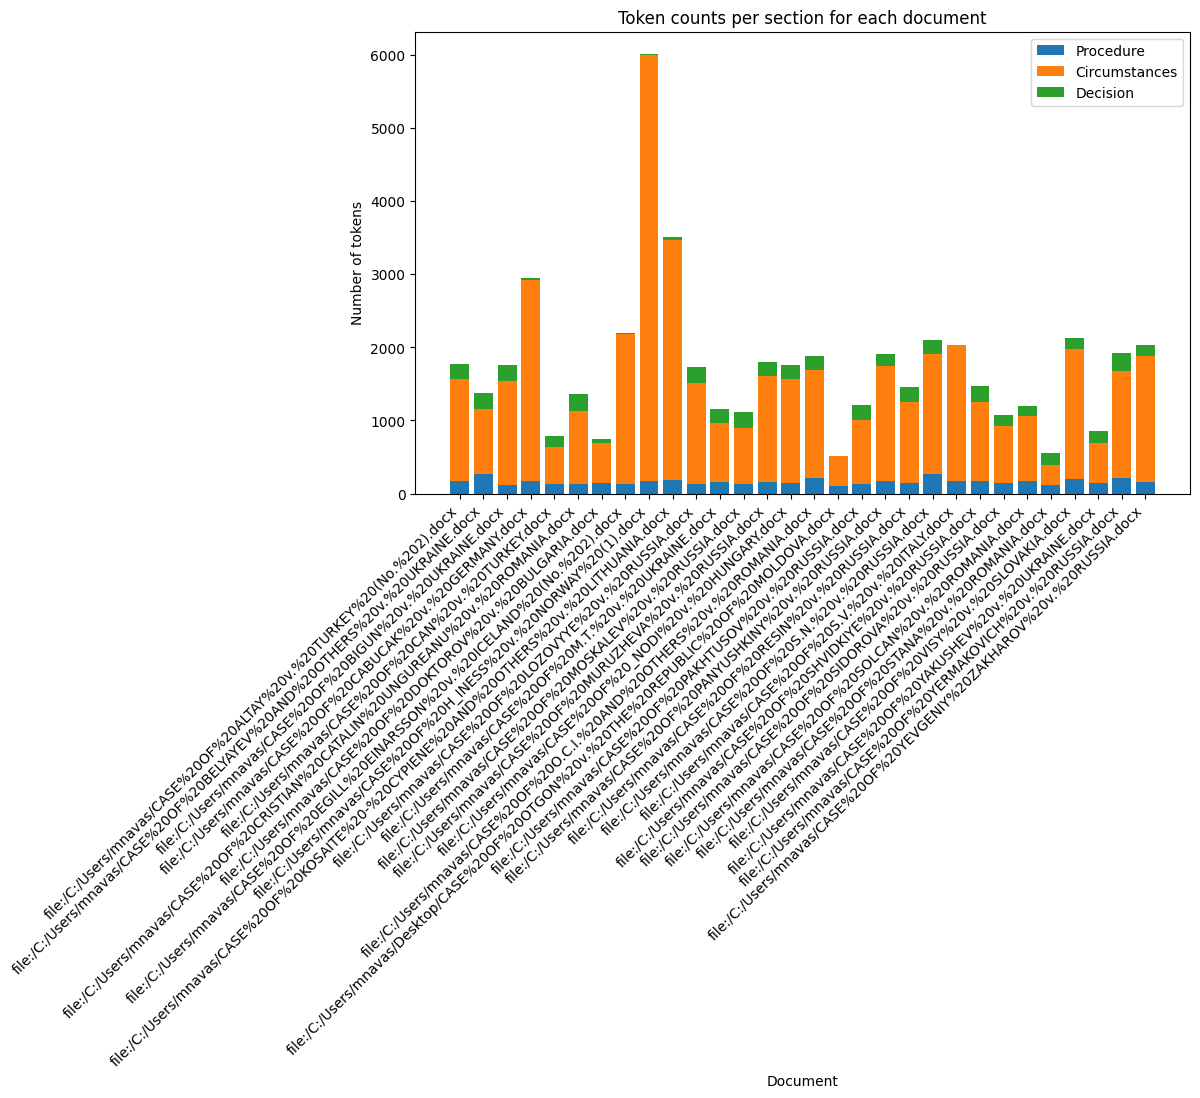

In [15]:
import matplotlib.pyplot as plt

doc_names = []
proc_counts = []
circ_counts = []
dec_counts = []

for doc in corpus:
    doc_name = doc.features.get("gate.SourceURL", "doc")
    doc_names.append(doc_name)
    annotations = doc.annset("Section")
    # Procedure
    proc_tokens = 0
    for ann in annotations.with_type("Procedure"):
        procedure_text = doc.text[ann.start:ann.end]
        proc_tokens += len(tokenizer(procedure_text))
    # Circumstances
    circ_tokens = 0
    for ann in annotations.with_type("Circumstances"):
        procedure_text = doc.text[ann.start:ann.end]
        circ_tokens += len(tokenizer(procedure_text))
    # Decision
    dec_tokens = 0
    for ann in annotations.with_type("Decision"):
        procedure_text = doc.text[ann.start:ann.end]
        dec_tokens += len(tokenizer(procedure_text))
    proc_counts.append(proc_tokens)
    circ_counts.append(circ_tokens)
    dec_counts.append(dec_tokens)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(doc_names, proc_counts, label='Procedure')
bar2 = ax.bar(doc_names, circ_counts, bottom=proc_counts, label='Circumstances')
bottoms = [p + c for p, c in zip(proc_counts, circ_counts)]
bar3 = ax.bar(doc_names, dec_counts, bottom=bottoms, label='Decision')

ax.set_ylabel('Number of tokens')
ax.set_xlabel('Document')
ax.set_title('Token counts per section for each document')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Procedure',
    x=doc_names,
    y=proc_counts
))
fig.add_trace(go.Bar(
    name='Circumstances',
    x=doc_names,
    y=circ_counts
))
fig.add_trace(go.Bar(
    name='Decision',
    x=doc_names,
    y=dec_counts
))

fig.update_layout(
    barmode='stack',
    title='Token counts per section for each document',
    xaxis_title='Document',
    yaxis_title='Number of tokens',
    xaxis_tickangle=-45,
    legend_title='Section',
    height=600,
    width=1000
)

fig.show()

### Check LLM Context Length Compatibility

In [5]:
import tiktoken
import pandas as pd
from typing import Dict, List, Tuple
from GatenlpUtils import loadCorpus

corpus = loadCorpus()

# Define representative models for each unique context length
# Only need to check one model per context length since capacity is the same
CONTEXT_LENGTHS = {
    4096: "gpt-3.5-turbo",
    8192: "gpt-4", 
    16384: "gpt-3.5-turbo-16k",
    32768: "gpt-4-32k",
    128000: "gpt-4-turbo",  # Also covers gpt-4o, llama-3.1 models
    200000: "claude-3-haiku",  # Also covers all Claude-3 models
    1000000: "gemini-1.5-flash",
    2000000: "gemini-1.5-pro"
}

# Full model mapping for reference (models with same context length)
ALL_MODELS = {
    # 4K context
    "gpt-3.5-turbo": 4096,
    
    # 8K context  
    "gpt-4": 8192,
    "llama-3-8b": 8192,
    "llama-3-70b": 8192,
    
    # 16K context
    "gpt-3.5-turbo-16k": 16384,
    
    # 32K context
    "gpt-4-32k": 32768,
    
    # 128K context
    "gpt-4-turbo": 128000,
    "gpt-4o": 128000,
    "llama-3.1-8b": 128000,
    "llama-3.1-70b": 128000,
    "llama-3.1-405b": 128000,
    
    # 200K context
    "claude-3-haiku": 200000,
    "claude-3-sonnet": 200000,
    "claude-3-opus": 200000,
    "claude-3.5-sonnet": 200000,
    
    # 1M context
    "gemini-1.5-flash": 1000000,
    
    # 2M context
    "gemini-1.5-pro": 2000000
}

def count_tokens_tiktoken(text: str, model: str = "gpt-4") -> int:
    """
    Count tokens using tiktoken for OpenAI models.
    Falls back to rough estimation for other models.
    """
    try:
        if model.startswith("gpt"):
            encoding = tiktoken.encoding_for_model(model)
        else:
            # Use cl100k_base encoding as approximation for other models
            encoding = tiktoken.get_encoding("cl100k_base")
        return len(encoding.encode(text))
    except Exception:
        # Fallback to rough estimation: ~4 characters per token
        return len(text) // 4

def check_context_compatibility(corpus, context_lengths: Dict[int, str], reserve_tokens: int = 1000) -> pd.DataFrame:
    """
    Check if document sections fit within LLM context lengths.
    Only checks one representative model per context length for efficiency.
    
    Args:
        corpus: GateNLP corpus
        context_lengths: Dictionary of context lengths and representative model names
        reserve_tokens: Tokens to reserve for system prompt, instructions, etc.
    
    Returns:
        DataFrame with compatibility results
    """
    results = []
    
    for doc_idx, doc in enumerate(corpus):
        doc_name = doc.features.get("gate.SourceURL", f"Document {doc_idx+1}")
        annotations = doc.annset("Section")
        
        # Extract text from each section
        procedure_text = ""
        circumstances_text = ""
        decision_text = ""
        
        for ann in annotations.with_type("Procedure"):
            procedure_text += doc.text[ann.start:ann.end] + " "
        
        for ann in annotations.with_type("Circumstances"):
            circumstances_text += doc.text[ann.start:ann.end] + " "
        
        for ann in annotations.with_type("Decision"):
            decision_text += doc.text[ann.start:ann.end] + " "
        
        # Count tokens for each section
        proc_tokens = count_tokens_tiktoken(procedure_text.strip())
        circ_tokens = count_tokens_tiktoken(circumstances_text.strip())
        dec_tokens = count_tokens_tiktoken(decision_text.strip())
        
        # Total tokens for all sections combined
        total_tokens = proc_tokens + circ_tokens + dec_tokens
        
        # Check compatibility with each unique context length
        for context_length, model_name in context_lengths.items():
            available_tokens = context_length - reserve_tokens
            
            result = {
                "document": doc_name,
                "context_length": context_length,
                "representative_model": model_name,
                "available_tokens": available_tokens,
                "procedure_tokens": proc_tokens,
                "circumstances_tokens": circ_tokens,
                "decision_tokens": dec_tokens,
                "total_tokens": total_tokens,
                "fits_individually": all([
                    proc_tokens <= available_tokens,
                    circ_tokens <= available_tokens,
                    dec_tokens <= available_tokens
                ]),
                "fits_combined": total_tokens <= available_tokens,
                "procedure_fits": proc_tokens <= available_tokens,
                "circumstances_fits": circ_tokens <= available_tokens,
                "decision_fits": dec_tokens <= available_tokens
            }
            
            results.append(result)
    
    return pd.DataFrame(results)

# Run the compatibility check (only checking unique context lengths)
print("Checking LLM context compatibility...")
compatibility_df = check_context_compatibility(corpus, CONTEXT_LENGTHS)

# Display summary
print("\nCompatibility Summary:")
print("=" * 60)

# Group by context length and show compatibility statistics
for context_length, model_name in CONTEXT_LENGTHS.items():
    model_data = compatibility_df[compatibility_df['context_length'] == context_length]
    total_docs = len(model_data)
    fits_individual = model_data['fits_individually'].sum()
    fits_combined = model_data['fits_combined'].sum()
    
    # Show which models have this context length
    models_with_this_length = [model for model, length in ALL_MODELS.items() if length == context_length]
    
    print(f"\nContext Length: {context_length:,} tokens")
    print(f"Representative model: {model_name}")
    print(f"Other models with same context: {', '.join([m for m in models_with_this_length if m != model_name])}")
    print(f"  Documents where all sections fit individually: {fits_individual}/{total_docs}")
    print(f"  Documents where all sections fit combined: {fits_combined}/{total_docs}")
    print(f"  Individual section compatibility:")
    print(f"    Procedure: {model_data['procedure_fits'].sum()}/{total_docs}")
    print(f"    Circumstances: {model_data['circumstances_fits'].sum()}/{total_docs}")
    print(f"    Decision: {model_data['decision_fits'].sum()}/{total_docs}")

Loaded input/updated/annotated\dev\CASE OF ALTAY v. TURKEY (No. 2).xml into corpus
Loaded input/updated/annotated\dev\CASE OF BELYAYEV AND OTHERS v. UKRAINE.xml into corpus
Loaded input/updated/annotated\dev\CASE OF BIGUN v. UKRAINE.xml into corpus
Loaded input/updated/annotated\test\CASE OF CABUCAK v. GERMANY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CAN v. TURKEY.xml into corpus
Loaded input/updated/annotated\test\CASE OF CRISTIAN CATALIN UNGUREANU v. ROMANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF DOKTOROV v. BULGARIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF EGILL EINARSSON v. ICELAND (No. 2).xml into corpus
Loaded input/updated/annotated\train\CASE OF HOINESS v. NORWAY.xml into corpus
Loaded input/updated/annotated\train\CASE OF KOSAITE - CYPIENE AND OTHERS v. LITHUANIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF LOZOVYYE v. RUSSIA.xml into corpus
Loaded input/updated/annotated\train\CASE OF M.T. v. UKRAINE

In [6]:
# Create detailed compatibility analysis
print("\nDetailed Document Analysis:")
print("=" * 80)

# Show documents that don't fit in smaller context models
problematic_docs = compatibility_df[
    (compatibility_df['context_length'] == 4096) & 
    (~compatibility_df['fits_combined'])
]['document'].unique()

if len(problematic_docs) > 0:
    print(f"\nDocuments that don't fit in 4K context models:")
    for doc in problematic_docs:
        doc_data = compatibility_df[
            (compatibility_df['document'] == doc) & 
            (compatibility_df['context_length'] == 4096)
        ].iloc[0]
        print(f"  {doc}: {doc_data['total_tokens']:,} tokens")

# Find the minimum context length needed for each document
print("\nMinimum context requirements per document:")
for doc in compatibility_df['document'].unique():
    doc_data = compatibility_df[compatibility_df['document'] == doc]
    max_tokens = doc_data['total_tokens'].iloc[0]  # Same across all context lengths for same doc
    
    # Find smallest context length that can handle this document
    suitable_contexts = doc_data[doc_data['fits_combined']]
    if not suitable_contexts.empty:
        min_context = suitable_contexts['context_length'].min()
        min_model = suitable_contexts[suitable_contexts['context_length'] == min_context]['representative_model'].iloc[0]
        print(f"  {doc}: {max_tokens:,} tokens -> Minimum: {min_context:,} tokens ({min_model})")
    else:
        print(f"  {doc}: {max_tokens:,} tokens -> No suitable context length found!")


Detailed Document Analysis:

Documents that don't fit in 4K context models:
  file:/C:/Users/mnavas/CASE%20OF%20CABUCAK%20v.%20GERMANY.docx: 3,716 tokens
  file:/C:/Users/mnavas/CASE%20OF%20H_INESS%20v.%20NORWAY%20(1).docx: 7,624 tokens
  file:/C:/Users/mnavas/CASE%20OF%20KOSAITE%20-%20CYPIENE%20AND%20OTHERS%20v.%20LITHUANIA.docx: 4,557 tokens

Minimum context requirements per document:
  file:/C:/Users/mnavas/CASE%20OF%20ALTAY%20v.%20TURKEY%20(No.%202).docx: 2,209 tokens -> Minimum: 4,096 tokens (gpt-3.5-turbo)
  file:/C:/Users/mnavas/CASE%20OF%20BELYAYEV%20AND%20OTHERS%20v.%20UKRAINE.docx: 1,803 tokens -> Minimum: 4,096 tokens (gpt-3.5-turbo)
  file:/C:/Users/mnavas/CASE%20OF%20BIGUN%20v.%20UKRAINE.docx: 2,355 tokens -> Minimum: 4,096 tokens (gpt-3.5-turbo)
  file:/C:/Users/mnavas/CASE%20OF%20CABUCAK%20v.%20GERMANY.docx: 3,716 tokens -> Minimum: 8,192 tokens (gpt-4)
  file:/C:/Users/mnavas/CASE%20OF%20CAN%20v.%20TURKEY.docx: 1,075 tokens -> Minimum: 4,096 tokens (gpt-3.5-turbo)
  fi

In [7]:
# Create visualization of context compatibility
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare data for heatmap
pivot_data = compatibility_df.pivot(index='document', columns='context_length', values='fits_combined')

# Create heatmap showing which documents fit in which context lengths
fig = px.imshow(
    pivot_data.astype(int),
    labels=dict(x="Context Length", y="Document", color="Fits"),
    title="Document Compatibility with LLM Context Lengths",
    color_continuous_scale=["red", "green"],
    aspect="auto"
)

# Update x-axis labels to show context lengths with model names
x_labels = [f"{length:,}\n({CONTEXT_LENGTHS[length]})" for length in sorted(CONTEXT_LENGTHS.keys())]
fig.update_xaxes(tickvals=list(range(len(x_labels))), ticktext=x_labels)

fig.update_layout(
    height=max(400, len(pivot_data) * 30),
    width=1000,
    xaxis_tickangle=-45
)

fig.show()

# Create bar chart showing token distribution
fig2 = go.Figure()

# Add bars for each section type (using one context length since tokens are same across all)
documents = compatibility_df[compatibility_df['context_length'] == 8192]['document'].tolist()
proc_tokens = compatibility_df[compatibility_df['context_length'] == 8192]['procedure_tokens'].tolist()
circ_tokens = compatibility_df[compatibility_df['context_length'] == 8192]['circumstances_tokens'].tolist()
dec_tokens = compatibility_df[compatibility_df['context_length'] == 8192]['decision_tokens'].tolist()

fig2.add_trace(go.Bar(name='Procedure', x=documents, y=proc_tokens))
fig2.add_trace(go.Bar(name='Circumstances', x=documents, y=circ_tokens))
fig2.add_trace(go.Bar(name='Decision', x=documents, y=dec_tokens))

# Add context length lines for different tiers
context_lines = [(4096, "4K models"), (8192, "8K models"), (128000, "128K models")]
for context_length, label in context_lines:
    fig2.add_hline(
        y=context_length - 1000,  # Reserve 1000 tokens
        line_dash="dash",
        line_color="red" if context_length < 10000 else "orange" if context_length < 100000 else "green",
        annotation_text=f"{label} limit"
    )

fig2.update_layout(
    barmode='stack',
    title='Token Distribution by Document with Context Length Limits',
    xaxis_title='Document',
    yaxis_title='Number of Tokens',
    height=600,
    width=1200,
    xaxis_tickangle=-45
)

fig2.show()

# Summary statistics
print("\nSummary Statistics:")
print("=" * 50)
total_docs = len(compatibility_df['document'].unique())
avg_total_tokens = compatibility_df.groupby('document')['total_tokens'].first().mean()
max_total_tokens = compatibility_df.groupby('document')['total_tokens'].first().max()
min_total_tokens = compatibility_df.groupby('document')['total_tokens'].first().min()

print(f"Total documents analyzed: {total_docs}")
print(f"Average total tokens per document: {avg_total_tokens:.0f}")
print(f"Maximum total tokens: {max_total_tokens:,}")
print(f"Minimum total tokens: {min_total_tokens:,}")

# Model recommendations
print("\nContext Length Recommendations:")
print("=" * 50)
context_tiers = [(4096, "4K models"), (8192, "8K models"), (128000, "128K models"), (200000, "200K models")]
for context_length, tier_name in context_tiers:
    if context_length in CONTEXT_LENGTHS:
        compatible_docs = compatibility_df[
            (compatibility_df['context_length'] == context_length) & 
            (compatibility_df['fits_combined'])
        ]['document'].nunique()
        
        percentage = (compatible_docs / total_docs) * 100
        
        # Show which models have this context length
        models_with_this_length = [model for model, length in ALL_MODELS.items() if length == context_length]
        
        print(f"{tier_name} ({context_length:,} tokens): {compatible_docs}/{total_docs} documents ({percentage:.1f}%) fit completely")
        print(f"  Available models: {', '.join(models_with_this_length)}")


Summary Statistics:
Total documents analyzed: 30
Average total tokens per document: 2283
Maximum total tokens: 7,624
Minimum total tokens: 789

Context Length Recommendations:
4K models (4,096 tokens): 27/30 documents (90.0%) fit completely
  Available models: gpt-3.5-turbo
8K models (8,192 tokens): 29/30 documents (96.7%) fit completely
  Available models: gpt-4, llama-3-8b, llama-3-70b
128K models (128,000 tokens): 30/30 documents (100.0%) fit completely
  Available models: gpt-4-turbo, gpt-4o, llama-3.1-8b, llama-3.1-70b, llama-3.1-405b
200K models (200,000 tokens): 30/30 documents (100.0%) fit completely
  Available models: claude-3-haiku, claude-3-sonnet, claude-3-opus, claude-3.5-sonnet


In [8]:
# Export compatibility results
output_file = "output/llm_context_compatibility.csv"
compatibility_df.to_csv(output_file, index=False)
print(f"Compatibility results saved to: {output_file}")

# Create a summary table for easy reference
summary_df = compatibility_df.groupby('context_length').agg({
    'fits_combined': 'sum',
    'fits_individually': 'sum',
    'procedure_fits': 'sum',
    'circumstances_fits': 'sum',
    'decision_fits': 'sum',
    'representative_model': 'first'
}).reset_index()

summary_df['total_documents'] = len(compatibility_df['document'].unique())
summary_df['combined_percentage'] = (summary_df['fits_combined'] / summary_df['total_documents'] * 100).round(1)

# Add column showing all models with this context length
summary_df['all_models'] = summary_df['context_length'].apply(
    lambda x: ', '.join([model for model, length in ALL_MODELS.items() if length == x])
)

print("\nContext Length Compatibility Summary:")
print(summary_df[['context_length', 'representative_model', 'fits_combined', 'total_documents', 'combined_percentage']].to_string(index=False))

print("\nAll models by context length:")
for _, row in summary_df.iterrows():
    print(f"{row['context_length']:,} tokens: {row['all_models']}")

Compatibility results saved to: output/llm_context_compatibility.csv

Context Length Compatibility Summary:
 context_length representative_model  fits_combined  total_documents  combined_percentage
           4096        gpt-3.5-turbo             27               30                 90.0
           8192                gpt-4             29               30                 96.7
          16384    gpt-3.5-turbo-16k             30               30                100.0
          32768            gpt-4-32k             30               30                100.0
         128000          gpt-4-turbo             30               30                100.0
         200000       claude-3-haiku             30               30                100.0
        1000000     gemini-1.5-flash             30               30                100.0
        2000000       gemini-1.5-pro             30               30                100.0

All models by context length:
4,096 tokens: gpt-3.5-turbo
8,192 tokens: gpt-4, ll